# Importation des données.

On commence par importer les modules dont on a besoin.

In [20]:
import pandas as pd 
import numpy as np
from datetime import datetime
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt


On importe ensuite les données sous forme de dtataframe. La commande date_parser = pd.to_datetime permet de convertir les dates ecrites sous la forme jour/mois/année heure:minute, qui sont importées en tant que stings, en objet de type date, avec lesquels on peut faire des manipulationc commes des soustractions par exemple. 

In [21]:
activity = pd.read_csv("1_Activity.csv",sep = ';', na_values = ['NULL'], dtype = {'duration': float}, parse_dates = ['date'])
acti_category = pd.read_csv("2_Activity_Category.csv",sep = ';',na_values = ['NULL'], encoding = "ISO-8859-1")
customer_lesson = pd.read_csv("4_Customer_Lesson.csv",sep = ';',na_values = ['NULL'], parse_dates = ['date'])
metric = pd.read_csv("6_Metric.csv",sep = ';', na_values = ['NULL'],  dtype = {'user_id': float, 'value': float}, parse_dates = ['date'])
metric_category = pd.read_csv("7_Metric_Category.csv",sep = ';',na_values = ['NULL'])
customer = pd.read_csv("11_Customer.csv",sep = ';',na_values = ['NULL'], parse_dates = ['createdAt'])
user = pd.read_csv("11_User.csv",sep = ';',na_values = ['NULL'])

cohorte = pd.read_csv('cohortes.csv', sep = ';',na_values = ['NULL'], parse_dates = ['createdAt'])

# on met les dates au format datetime, qui permet de faire des soustractions et des sommes de dates.
date_parser = pd.to_datetime 

Dans user les dates ne sont pas converties grace à parse_dates. Il faut donc le faire séparément. On créer une série birthday qui contient les dates au bon format, et on la met dans user à la place de la colonne birthday déja présente. 

In [22]:
birthday = pd.to_datetime(user['birthday'], format='%d/%m/%Y', errors = 'coerce')
user = user.drop(['birthday'], axis = 1)

user['birthday'] = birthday

On créé un tableau contenant : user_id, customer_id et les affectations aux cohortes. Ce tableau remplace le tableau customer.

In [23]:
cohorte = cohorte.drop(['deletedAt','updatedAt', 'createdAt', 'Unnamed: 9', 'height', 'weight', 'gender', 'user_id'], axis = 1)

customer = customer.drop(['deletedAt', 'updatedAt'], axis = 1)
customer = customer.merge(cohorte ,left_on = 'id', right_on = 'id', how = 'outer')
customer = customer.sort_values(by = ['disease_id', 'id'])
customer = customer.reset_index(drop = True)

user.rename(columns = {'id': 'user_id'}, inplace = True)
customer.rename(columns = {'id': 'customer_id'}, inplace = True)

# Calcul des KPI

## Implication sur les 3 premières semaines

   On va compter le nombre d'actions volontaires effectuées par chaque user. Ceci exclue par exemple les nombres de pas qui sont enregistrés par les podomètres, et qui necessitent juste d'avoir l'application ouverte. On commence par ecrire une fonction qui compte les actions volontaire de chaque user dans metric durant les 21 premiers jours. La fonction prend en argument le tableau metrics, et un tableau time début qui contient les dates de debut du programme pour chaque user.

   Pour faire ceci, on créé une liste c qui va sélectionner les user_id dans metrics (il faut ensuite supprimer les doublons). On créé une liste vide tot qui va contenir le nomnbre d'actions faites par chaque user. Ensuite, pour chaque user, on créé un tableau A pour chaque user, où on sélectionne les lignes qui correspondent à des actions volontaires. On se réfère au tableau activity_category pour cela. Ensuite on créé un tableau B qui ne contient en fait qu'une valeur : la date de début du programme pour le user en question. Ensuite on compte les actions effectuées moins de 21 jours après le début du programme.

In [24]:
def count_voluntary_actions(metric,time_debut): 
    
    c = np.array(metric['user_id']) 
    c = np.array(list(set(c))) 
    tot = []
    
    for i in range(len(c)):
        A = metric[metric['user_id'].isin([c[i]])] 
        A = A[A['category_id'].isin([14,15,16,17,18,19,20,21,22])]
        B = time_debut[time_debut['user_id'].isin([c[i]])]
        
        A = A.reset_index(drop = True)
        B = B.reset_index(drop = True)
        
        n,l = 0,A.shape[0]
        
        for k in range(0,l) : 
             if A.loc[k,'date']-B.loc[0,'createdAt'] <= timedelta(days=21):
                n+=1
        tot.append(n)
        
    return(tot)

On ecrit une fonction qui compte le nombre d'activités faites dans les 21 premiers jours. Elle fonctionne de la même manière que la fonction count_voluntary_actions sauf qu'ici le tableau A créé a chaque itération contient la liste des activités faites ou non par chaque user.

In [25]:
def imp_acti(activity,time_debut):
    
    c = np.array(activity['customer_id']) 
    c = np.array(list(set(c))) 
    tot = []

    for i in range(len(c)):
        A = activity[activity['customer_id'].isin([c[i]])]
        A = A.reset_index(drop = True)
        
        B = time_debut[time_debut['customer_id'].isin([c[i]])]
        B = B.reset_index(drop = True)
        
        n,l = 0,A.shape[0]
        
        for k in range(l):
            if A.loc[k,'date']-B.loc[0,'createdAt'] <= timedelta(days=21) :
                if A.loc[k,'state']=='done':
                    n+=1
        tot.append(n)

    return(tot)

Puis une fonction qui compte le nombre de leçons faites les 21 premiers jours. Elle fonctionne de manière analogue aux deux fonctions précédentes.

In [26]:
def imp_lesson(lesson,time_debut):
    c = np.array(lesson['customer_id']) 
    c = np.array(list(set(c))) 
    tot = []
    
    for i in range(len(c)):
        A = lesson[lesson['customer_id'].isin([c[i]])]
        A = A.reset_index(drop = True)
         #on va cherhcer la date de début de programme pour le user en question.
        
        B = time_debut[time_debut['customer_id'].isin([c[i]])]
        B = B.reset_index(drop = True)
        #on va cherhcer la date de début de programme pour le user en question.
        
        n,l = 0, A.shape[0]
        
        for k in range(l):
            #on selectionne les leçons faites dans les premières semaines
            if A.loc[k,'date']-B.loc[0,'createdAt'] <= timedelta(days = 21):
                if A.loc[k,'state'] == 'done':
                    n += 1
        tot.append(n)
    return(tot)

Puis une fonction implication qui va utiliser les trois fonctions précédentes et regrouper leur résultats dans un seul tableau. C'est dans cette fonction que l'on créé le tableau time_debut qui contient les dates de début du programme pour chaque user.

In [27]:
def implication():
    
#---------------------------customer et user----------------------------------#
    customer_df = customer.copy()
    
    user_df = user.copy()
    user_df = user_df.drop(['deletedAt', 'updatedAt'], axis = 1)
#-------------------------------metrics------------------------------------#
    metric_df = metric.copy()
    metric_df = metric_df.drop(['deletedAt', 'id', 'updatedAt','createdAt'], axis=1)
    metric_df = metric_df.drop_duplicates()
    metric_df = metric_df.sort_values(by =['user_id','category_id']) # tri des valeurs.
    metric_df = metric_df.reset_index(drop = True) #réindexation.
#---------------------------------leçons--------------------------------------#
    lesson_df = customer_lesson.copy()
    del lesson_df['id']
    lesson_df = lesson_df.sort_values(by = ['customer_id','date'])
    lesson_df = lesson_df.reset_index(drop = True)
#-------------------------------Activity--------------------------------------#
    acti = activity.copy()
    acti = acti.drop(['id','feedback_text','feedback_rate','deletedBy_id','updatedBy_id','createdBy_id','deletedAt','updatedAt','createdAt'], axis=1)
    acti = acti.sort_values(by = ['customer_id'])
    acti = acti.drop([48410 + i for i in range(150)], axis = 0)
    acti = acti.reset_index(drop = True)
#-----------------------------------------------------------------------------#
    time_debut = customer.copy(deep = True) 
    time_debut = time_debut.drop(['gender','weight','height'], axis = 1)
#-----------------------------------------------------------------------------#

    implication_metrics = pd.DataFrame({'user_id': np.array(list(set(metric_df['user_id']))),'nbr_metrics' : count_voluntary_actions(metric_df,time_debut)})
    implication_metrics = implication_metrics.sort_values(by = ['user_id'])
    implication_metrics = implication_metrics.reset_index(drop = True)

    implication_lesson = pd.DataFrame({'customer_id': np.array(list(set(lesson_df['customer_id']))),'nbr_lecon_faites' : imp_lesson(lesson_df,time_debut) })
    implication_lesson = implication_lesson.sort_values(by = ['customer_id'])
    implication_lesson = implication_lesson.reset_index(drop = True)

    implication_acti = pd.DataFrame({'customer_id': np.array(list(set(acti['customer_id']))),'nbr_acti_faites' : imp_acti(acti,time_debut)})
    implication_acti = implication_acti.sort_values(by = ['customer_id'])
    implication_acti = implication_acti.reset_index(drop = True) 

    implication_3_weeks = customer.merge(implication_lesson,left_on = 'customer_id', right_on = 'customer_id', how = 'outer')

    implication_3_weeks = implication_3_weeks.merge(implication_acti,left_on = 'customer_id', right_on = 'customer_id', how = 'outer')

    implication_3_weeks = implication_3_weeks.merge(implication_metrics,left_on = 'user_id', right_on = 'user_id', how = 'outer')

    implication_3_weeks = implication_3_weeks.drop(['user_id', 'disease_id', 'createdAt','gender', 'weight', 'height'], axis = 1)

    return(implication_3_weeks)

# KPI des pas.

On s'intéresse au nombre de pas réalisé par chaque utilisateur. Ces informations sont dans le tableau metrics ; elles correspondent aux category_id 5, 6 et 7. On somme tous les pas pour chaque utilisateur, et on récupère aussi la plage temporelle pendant laquelle tous ces pas ont été effectués.

In [28]:
def KPI_pas():
    extraction_pas=metric[metric['category_id'].isin([5,6,7])]
    
    extraction_pas = extraction_pas.drop(['deletedAt', 'id', 'updatedAt', 'createdAt' ], axis = 1)
 
    extraction_pas = extraction_pas.drop_duplicates()
    
    extraction_pas = extraction_pas.reset_index(drop = True)
    
    #on declare toutes les variables dont on aura besoin dans la suite du programme
    somme_pas , date_debut, date_fin, temps_activite = [], [], [], []
    
    l, date_debut_float, date_fin_float = 0, 0, 0
 
    KPI_pas, KPI_valide,KPI_pas_duree, KPI_pas_data, nb_de_data  = [], [], [], [], []
    
    delta_temps = timedelta(0)
    
    indice, length,sum_steps = 0, 0, 0
  
    #on cree la liste avec juste les id des users de facon unique
    users=list(set(extraction_pas['user_id']))
    
    #on va creer les listes qui vont correspondre aux colonnes de la nouvelle dataframe
    
    for i in users:
        
        #on definit une variable temporaire df_temp qui est une copy de extraction_pas mais où il y a seulement les lignes qui correspondent à un seul user_id
        df_temp=extraction_pas[extraction_pas['user_id'].isin([i])]
        df_temp=df_temp.reset_index(drop=True)
        
        #on trie par date
        df_temp=df_temp.sort_values(by=['date'])
        df_temp=df_temp.reset_index(drop=True)
        
        #on somme toute les donnees de pas et on les stocke dans une liste somme_pas
        somme_pas.append(df_temp.sum().value)
        
        #on pose la variable contenant la date de debut de l'activite physique
        date_debut_float=df_temp.loc[0,'date']
        
        #on fait de meme avec la variable contenant la date de fin de l'activite physique
        l=df_temp.shape[0]
        date_fin_float=df_temp.loc[l-1,'date']
        
        #on stocke la difference de temps (en jours) dans la liste temps_activite
        temps_activite.append(date_fin_float-date_debut_float)
        
        #on attribue la valeur a la variable length qui va servir a compter le nombre de données disponibles pour chaque user_id que l'on stocke ensuite dans la liste nb_de_data
        length=len(df_temp)
        nb_de_data.append(length)
        
        #on initialise ici une variable qui sera utile pour compter le nb de pas total sur une duree de 120 jours
        sum_steps=0
        date1=0
        indice=0
        delta_temps=timedelta(0)
        
        
        #maintenant que l'on a recuperé toutes les donnees de pas pour un utilisateur, on va étudier comment se sont passer les 120 premiers jours d'activité
        
        #d'abord on regarde les users qui ont un temps total d'activité physique entre 30 et 120 jours. La valeur 30 est arbitraire pour exclure les gens qui n'auraient fait des pas que sur les 30 premiers jours.
        #Pour avoir une donnee du nombre de pas sur 120 jours, on fait une moyenne sur le temps d'activité reel que l'on remet sur 120 jours et on stocke tout ca dans KPI_pas. Ensuite dans KPI_pas_duree, on mets la duree reele sur laquelle s'est produite l'entiereté de l'activité physique et dans KPI_pas_data on mets le nombre de données que l'on possède.
        if temps_activite[-1]<timedelta(120) and temps_activite[-1]>timedelta(30):
            KPI_pas.append(somme_pas[-1]/temps_activite[-1].days*120)
            KPI_pas_duree.append(temps_activite[-1])
            KPI_pas_data.append(length)
            
        #on fait de meme avec les gens qui ont pile 120 jours d'activité (je sais pas si il y en a vraiment, mais on sait jamais)
        elif temps_activite[-1]==timedelta(120):
            KPI_pas.append(somme_pas[-1])
            KPI_pas_duree.append(temps_activite[-1])
            KPI_pas_data.append(length)
            
        #Ici, c'est le cas des gens qui ont moins de 30 jours de donnees. Du coup, on decide arbitrairement que ca ne suffit pas pour avoir des resultats fiables, et on remplit les liste de facon conséquente (KPI_pas=NaN)
        elif temps_activite[-1]<=timedelta(30):
            KPI_pas.append(np.nan)
            KPI_pas_duree.append(temps_activite[-1])
            KPI_pas_data.append(length)
            
        #Le cas le plus complexe est quand la personne a plus de 120 jours de données. En effet, il y a peu de chances que l'on ait une donnée de son nombre de pas exactement le 120eme jour apres qu'il ait commencé le programme. Du coup on essaye de prendre la somme des pas jusqu'au dernier jour où on a des données avant de passer la barre des 120 jours
        elif temps_activite[-1]>timedelta(120):
            
            #on fait une boucle while qui finira quand on aura passé la barre des 120 jours
            while delta_temps<timedelta(120):
                sum_steps +=df_temp['value'][indice] #on somme les pas de chaque jour
                indice += 1
                delta_temps = df_temp['date'][indice]-date_debut_float #on avance jusqu'au prochain jour
            
            #maintenant la variable "indice" pointe à la ligne correspondant au jour où on possède de la donnée qui suit le jour 120, il faut donc bien attribuer la bonne valeur à delta_temps pour pointer au jour où la donnee est disponible avant le jour 120.
            date1 = df_temp['date'][indice - 1] - date_debut_float
            
            #on ajoute dans KPI_pas la moyenne sur les 120 premiers jours et on rempli les autres listes en fonction
            KPI_pas.append(sum_steps/date1.days*120)
            KPI_pas_duree.append(date1)
            KPI_pas_data.append(indice-1)
        
        #maintenant on crée la derniere liste correspondant à si la personne a bien validé le KPI des pas
        if KPI_pas[-1] >= 840000:
            KPI_valide.append(1)
        else:
            KPI_valide.append(0)
    
    
    #on va creer un nouveau dataframe qui regroupe toutes les informations qu'on a recueillis
    recap = pd.DataFrame({"user_id" : users, "pas_total" : somme_pas, "pas_duree_total" : temps_activite, "pas_data_total" : nb_de_data, "KPI_pas" : KPI_pas, "KPI_pas_duree" : KPI_pas_duree, "KPI_pas_data": KPI_pas_data, "KPI_pas_done" : KPI_valide})
    recap = recap.sort_values(by = 'user_id')
    recap = recap.reset_index(drop = True)
    
    return(recap)


# KPI des leçons

Cette fonction va étudier l'assiduité des utilisateurs face aux leçons. Elle prend en argument un tableau input_df (ici customer_lesson), id_name (qui est le nom de l'id qui permet d'identifier les données intéressantes dans input_df. Dans customer_lesson il s'agit de lesson_id), et KPI_name (le nom que l'on va donner à notre KPI, ici KPI_lesson).
ce tableau contiendra les colonnes customer_id, KPI_lesson (le pourcantage de leçons effectuées) et KPI_lesson_done (qui vaut 1 si KPI_lesson>0,66 - i.e si le customer a fait au moins deux tiers des leçons - 0 sinon).

In [29]:
def KPI_lesson(input_df, id_name, KPI_name):
# get the rows
    customer_lesson_col = input_df['lesson_id']
    customer_id_col = input_df['customer_id']
# count the number of lessons for each customer
    customer_count_dic = {}
    for i in customer_id_col:
        customer_count_dic[i] = customer_count_dic.get(i, 0) + 1
        
# count the number of lessons done for each customer
    customer_activity_done_df = input_df[input_df['state'] == 'done']
    customer_done_lesson_col = customer_activity_done_df['lesson_id']
    customer_done_id_col = customer_activity_done_df['customer_id']
    customer_done_count_dic = {}
    for i in customer_done_id_col:
        customer_done_count_dic[i] = customer_done_count_dic.get(i, 0) + 1
# calculate the KPI for each customer
    rate_dic = {}
    for i in customer_count_dic.keys():
        try:
            rate_dic[i] = float(customer_done_count_dic[i])/float(customer_count_dic[i])
        except:
            rate_dic[i] = 0
            
# put the KPI in dataframe
    col_customer_id = list(rate_dic.keys())
    col_KPI_lesson = []
    for i in col_customer_id:
        col_KPI_lesson.append(rate_dic[i])
    d = {id_name:col_customer_id, KPI_name:col_KPI_lesson}
    KPI_df = pd.DataFrame(data=d)
    
    #Ajout de KPI_lesson_done###
    KPI_lesson_done = []
    for value in KPI_df.KPI_lesson:
        if value >= 0.65:
            KPI_lesson_done.append(1)
        elif value < 0.65 : 
            KPI_lesson_done.append(0) 
        else :
            KPI_lesson_done.append(np.nan)
    KPI_df['KPI_lesson_done'] =  KPI_lesson_done
    KPI_df.rename(columns = {'lesson_id': 'customer_id'}, inplace = True)
    
    return(KPI_df)


# KPI des MET

In [30]:
def KPI_MET():
    
    acti = activity
    
    # On va mettre en forme pour obtenir un 1er tableau df récapitulant les donnés utiles
    
    #On supprime les colones utiles
    acti = acti.drop(['id','feedback_text','feedback_rate','deletedBy_id','updatedBy_id', 'createdBy_id','createdAt','deletedAt','updatedAt'], axis = 1)

    #On sélectionne uniquement les personnes qui ont bien fait l'activité 
    acti = acti[acti['state'] == "done"]  
    
    del acti['state']    

    activity_category = acti_category[['id','MET']]
    
    #On obtient un tableau en faisant une jointure 
    df = pd.merge(acti,activity_category,left_on = 'category_id',right_on = 'id')
    
    df = df[['customer_id','duration','MET','date']]
    
    #On obtient la valeur totale des MET de l'activité 
    df = df.assign(value=lambda df: df.duration*df.MET)
    df = df[['customer_id','value','date']]
    #On trie par id et on supprime les activités qui ne rapportent pas de MET
    df.sort_values(by = 'customer_id')
    df = df[df['value'] != 0]
    
    #On ré-initialise l'index à partir de 0. A partir de là on va travailler pour extraire les informations utiles du tableau df.
    df = df.reset_index(drop=True) 
    
    
    
    #On declare toutes les variables dont on aura besoin dans la suite du programme
    somme_MET, l = [], 0
    temps_activite=[]
    date_debut_float=0
    date_fin_float=0
    KPI_MET=[]
    delta_temps=timedelta(0)
    indice=0
    nb_de_data=[]
    length=0
    sum_steps=0
    KPI_valide=[]
    KPI_MET_duree=[]
    KPI_MET_data=[]
    users=list(set(df['customer_id'])) #on cree la liste avec juste les id des users de facon unique
    
    #On va creer des listes pour creer le nouveau dataframe qui récapitulera tout
    for i in users:
        
        #On crée une liste temporaire qui contient les informations utiles pour l'utilisateur i 
        df_temp = df[df['customer_id'].isin([i])]
        df_temp = df_temp.reset_index(drop = True)
        #On trie par date et on ré-index
        df_temp = df_temp.sort_values(by = ['date'])
        df_temp = df_temp.reset_index(drop = True)
        #On somme l'ensemble des MET réalisés par l'utilisateur i sur sa période
        somme_MET.append(df_temp.sum().value)
        #On obtient la date de début, et de fin, de son activité : ce qui permet d'obtenir la durée totale de son activité 
        date_debut_float = df_temp.loc[0,'date']
        #date_debut.append(date_debut_float)
        l= df_temp.shape[0]
        date_fin_float = df_temp.loc[l-1,'date']
        #date_fin.append(date_fin_float)
        temps_activite.append(date_fin_float-date_debut_float)
        #On obtient la longueur de la liste, qui correspond aux nombres d'activités (nombre de données) faites par l'utilisateur i 
        length = len(df_temp)
        nb_de_data.append(length)
        sum_steps = 0
        indice = 0
        delta_temps = timedelta(0)
        
        #1er cas : l'utilisateur est membre du programe depuis moins de 120 jours mais plus de 30 jours
        if temps_activite[-1] < timedelta(120) and temps_activite[-1]>timedelta(30):
            #On réalise un moyenne des MET réalisés par jour jusqu'à présent et on l'étend sur 120 jours par régression linéaire
            KPI_MET.append(somme_MET[-1]/temps_activite[-1].days*120)
            #On rajoute le temps d'activté à la liste 
            KPI_MET_duree.append(temps_activite[-1])
            #On rajoute le nombre d'activités réalisées
            KPI_MET_data.append(length)
        
        #2nd cas : l'utilisateur est membre du programe depuis pile 120 jour
        elif temps_activite[-1] == timedelta(120):
            #On a directement la somme des MET réalisé par l'utilisateur, ainsi que son temps d'activité et son nombre d'activité
            KPI_MET.append(somme_MET)
            KPI_MET_duree.append(temps_activite[-1])
            KPI_MET_data.append(length)
        
        #3ème cas : l'utilisateur est membre du programe depuis moins de 30 jours, ses données ne sont pas assez nombreuses pour le considérer
        elif temps_activite[-1] <= timedelta(30):
            KPI_MET.append(np.nan)
            KPI_MET_duree.append(temps_activite[-1])
            KPI_MET_data.append(length)
        
        #4ème cas : l'utilisateur est membre du programe depuis plus de 120 jours, on va être limiter de limiter ses MET à ceux réalisés durant les 120 premiers jours
        elif temps_activite[-1] > timedelta(120):
            #On calcule les MET sur les 120 premiers jours ainsi que la durée sur laquelle il les a réalisé (qui peut être inférieur à 120jours)
            while delta_temps<timedelta(120):
                sum_steps += df_temp['value'][indice]
                indice += 1
                delta_temps = df_temp['date'][indice]-date_debut_float
            delta_temps = df_temp['date'][indice-1]-date_debut_float
            KPI_MET.append(sum_steps)
            KPI_MET_duree.append(delta_temps)
            KPI_MET_data.append(indice-1)

        # On détermine sur l'utilisateur a atteint le KPI : 9000 MET en 120 jours
        if KPI_MET[-1]>=9000:
            KPI_valide.append(1)
        else:
            KPI_valide.append(0)
    
    #On va creer un nouveau dataframe récapitulant ces informations pour chaque utilisateur
    recap = pd.DataFrame({"customer_id" : users, "MET_total" : somme_MET, "MET_duree_total" : temps_activite, "MET_data_total" : nb_de_data, "KPI_MET" : KPI_MET, "KPI_MET_duree" : KPI_MET_duree, "KPI_MET_data": KPI_MET_data, "KPI_MET_done" : KPI_valide})
    recap = recap.sort_values(by = 'customer_id')
    recap = recap.reset_index(drop = True)
    
    return(recap)

## KPI du poids

On commence par nettoyer les données, car il y'a des valeurs abérentes. On va regarder la moyenne du poids de chaque utilisateur, et si une valeur est éloignée de plus de 30%, on la met à la moyenne. 

In [31]:
def nettoyage(extraction_poids):
    c = np.array(extraction_poids['user_id']) #liste des user_id dans extraction_poids
    c = np.array(list(set(c))) # on vire les doublons
    tot = []
    #---------------------------# 
    for i in range(len(c)):
        #on extrait une sous-table pour chaque user
        A = extraction_poids[extraction_poids['user_id'].isin([c[i]])]
        A = A.reset_index(drop = True)
        
        avg = A['value'].mean() 
       
        l = A.shape[0]
    
        for k in range(l): 
            if abs(avg - A.loc[k,'value'])/avg >= 0.25 : #30% d'écart à la moyenne
                A.loc[k,'value'] = avg
          
        #traitement des grandes variations    
        for k in range(1,l):
            if abs(A.loc[k-1,'value'] - A.loc[k,'value']) >= 7:
                if (A.loc[k,'date']- A.loc[k-1,'date']) <= timedelta(days = 14):
                     A.loc[k,'value'] = A.loc[k-1,'value']
                     
        #traitement des petites variations  
        for k in range(1,l):
            if abs(A.loc[k-1,'value']-A.loc[k,'value']) >= 4:
                if (A.loc[k,'date']- A.loc[k-1,'date']) <= timedelta(days = 4):
                     A.loc[k,'value'] = A.loc[k-1,'value']
                     
        tot.append(A)
    #---------------------------# 
    poids = tot[0]
    for i in range(1,len(tot)):
        poids = pd.concat([poids,tot[i]])

    return(poids)

On écrit ensuite une fonction KPI_poids qui calcule en fait la perte de poids de chaque utilisateur en pourcentage de son poids initial. Donc un pourcentage positif signifie une perte de poids, un pourcentage négatif un gain de poids.
Le tableau va contenir les colonnes suivantes : 'user_id', 'periode' (temps passé entre les deux mesures de poids les plus éloignées dans le temps pour chaque user), 'nombre_données' (le nombre de mesures de poids pour chaque user), 'perte_de_poids' (le pourcentage de perte de poids), et le poids initial et le poids final.

In [32]:
def KPI_poids():
    
    #on prend les lignes qui ne correspondent qu'au poids. La catégorie du poids est 16
    extraction_poids = metric[metric['category_id'].isin([16])] 
    
    extraction_poids = extraction_poids.drop(['deletedAt','id', 'updatedAt','createdAt', 'deletedAt'], axis = 1)
    
    #on trie par user_id croissant
    extraction_poids = extraction_poids.sort_values(by = 'user_id')
    
    # Il y'a des lignes identiques - on les retire : 
    extraction_poids = extraction_poids.drop_duplicates()
      
    #tri temporel par user
    extraction_poids = extraction_poids.sort_values(by = ['user_id','date'])

    extraction_poids = extraction_poids.reset_index(drop = True) 
    
    poids = nettoyage(extraction_poids)  
    
    #tri temporel par user
    poids = poids.sort_values(by = ['user_id','date'])
    
    poids = poids.reset_index(drop = True) 
    
    c = np.array(poids['user_id']) #liste des user_id dans extraction_poids.
    c = np.array(list(set(c))) # on vire les doublons.
    P = [] # liste des pertes de poids
    T = [] # liste du temps passé dans le programme
    val = [] # liste des nombre de valeurs 
    ini = []
    fin = []
    #---------------------------# 
    for i in range(len(c)):
        #on extrait une sous-table pour chaque user.
        A = poids[poids['user_id'].isin([c[i]])]
        A = A.reset_index(drop = True)
        l = A.shape[0]
        
        perte = -100*(A.loc[l-1,'value']-A.loc[0,'value'])/A.loc[0,'value']
        
        time = A.loc[l-1,'date']- A.loc[0,'date']
        
        fin.append(A.loc[l-1,'value'])
        ini.append(A.loc[0,'value'])
        P.append(perte)
        T.append(time)
        val.append(l)
    #---------------------------# 
    KPI_poids = pd.DataFrame({'user_id': c, 'perte_de_poids' : P, 'periode' : T, 'nombre_données' : val, 'poids_ini' : ini, 'poids_fin' : fin })
    
    KPI_poids = KPI_poids.sort_values(by = ['user_id'])
    KPI_poids = KPI_poids.reset_index(drop = True) 
    
    return(KPI_poids)

# Visualisation et analyse.

On écrit d'abord quelques fonctions intermédiaires qui vont servir dans la suite du programme. Les deux premières permettent de de calculer l'age des utilisateurs, la deuxième est une fonction de nettoyage.

In [33]:
def calculate_age(born): 
    today = datetime.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

def age(df): 
    age = []
    for item in df.birthday:
        delta = calculate_age(item)
        age.append(delta)
    age_df = pd.DataFrame({'user_id': df['user_id'], 'age' : age })
    return(age_df)
                        
    df['age'] =  age
    df1 = df.loc[:,['user_id','age']]
    return df1

def nett(df,a,b): #Nettoyage des valeurs non comprises entre [a,b]
    temp=[]
    for i in df : 
        if i<b and i>a:
            temp +=[i]
        else :
            temp += [np.nan]
    df = temp
    return df


Puis on créé un tableau qui regroupe tous les KPI, en fusionnant les résultats des fonctions KPI_pas, KPI_MET, implication et KPI_poids. On rajoute aussi la taille et le poids des users, en retirant les erreurs

In [34]:
def init():
    global customer
    
    KPI_df = customer.copy(deep = True)
    
    KPI_df = KPI_df.merge(age(user),left_on = 'user_id', right_on = 'user_id', how = 'outer') #Ajoute de l'age à customer
    
    KPI_df.height = nett(customer.height,130,200) #On retire les gens inferieurs à 130cm et supérieurs à 200cm
    KPI_df.weight = nett(customer.weight,40,200) #On retire les gens inferieurs à 40kg et supérieurs à 150kg
    
    #Ajout du KPI_lesson calcule dans  Gao_KPI_lesson
    KPI_df = KPI_df.merge(KPI_lesson(customer_lesson,'lesson_id','KPI_lesson'),left_on = 'customer_id', right_on = 'customer_id', how='outer') 
    
    #Ajout du KPI_poids calcule dans  Hugo_KPI_poids
    KPI_df = KPI_df.merge(KPI_poids(),left_on = 'user_id', right_on = 'user_id', how = 'outer') 
    KPI_df.rename(columns = {'Perte_de_poids': 'Perte_de_poids (% du poids initial)'}, inplace = True)
    KPI_df.rename(columns = {'periode': 'Periode de perte de poids'}, inplace = True)
    
    #Ajout du KPI_pas calcule dans  Felix_KPI_pas
    KPI_df = KPI_df.merge(KPI_pas(),left_on = 'user_id', right_on = 'user_id', how = 'outer') 
    KPI_df.rename(columns = {'somme pas': 'KPI_pas'}, inplace=True)
    
    #Ajout du KPI_pas calcule dans  Kunsch_KPI_MET
    KPI_df = KPI_df.merge(KPI_MET(),left_on = 'customer_id', right_on = 'customer_id', how = 'outer') 
    KPI_df.rename(columns = {'METa': 'KPI_MET'}, inplace = True)
    
    #Drop les colonnes useless
    KPI_df = KPI_df.drop(['createdAt'], axis = 1) 
    
    #Ajout du KPI_pas calcule dans implication_3_weeks
    KPI_df = KPI_df.merge(implication(),left_on = 'customer_id', right_on = 'customer_id', how = 'outer') 

    return(KPI_df)

On va ensuite afficher une matrice de corrélation entre différents paramètres du tableau final. Pour cela on en créé une copy KPI_mat_corr, dont on retire les colonnes que l'on en veut pas voir dans la matrice de corrélation.

/Users/ariane/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in double_scalars


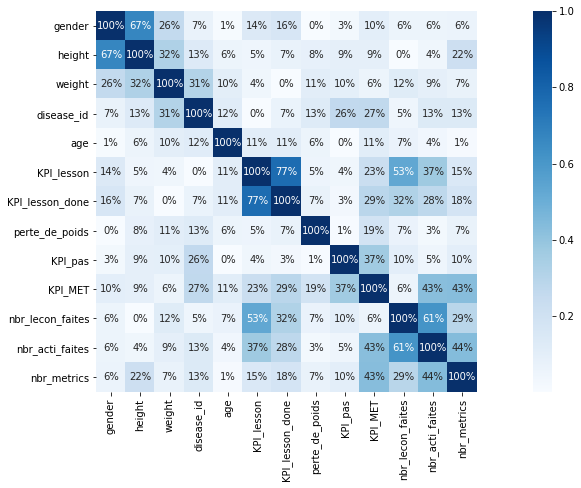

In [35]:
KPI_df = init()
KPI_df
df1 = KPI_df.loc[:,['gender','age','height','weight']]
            
df1 = df1.astype(float)
df1 = df1.sort_values(by = 'gender') #Trie 
plt.figure()

plt.figure(figsize = (20,7))
    
KPI_mat_corr = KPI_df.copy()
KPI_mat_corr = KPI_mat_corr.drop(['customer_id','user_id','nombre_données','poids_ini','poids_fin','Periode de perte de poids'], axis=1)
KPI_mat_corr = KPI_mat_corr.drop(['KPI_pas_data', 'KPI_pas_done','pas_data_total','pas_total','KPI_pas_duree','pas_duree_total'], axis=1)
KPI_mat_corr = KPI_mat_corr.drop(['KPI_MET_done','KPI_MET_data','MET_data_total','MET_total','KPI_MET_duree','MET_duree_total'], axis=1)
sns.heatmap(abs(KPI_mat_corr.corr()), square = True, annot = True, fmt='.0%',cmap = "Blues")


In [36]:
df = KPI_df[KPI_df['user_id'].isin([578,579,588])]
df = df.drop(['KPI_MET_data', 'MET_data_total', 'MET_duree_total', 'KPI_pas_duree', 'KPI_pas_data'  ], axis = 1)
df = df.drop(['pas_total', 'pas_duree_total', 'pas_data_total', 'KPI_MET_duree'], axis = 1)
df = df.drop(['Periode de perte de poids', 'nombre_données', 'nombre_données', 'nbr_metrics', 'nbr_lecon_faites'], axis = 1)
df

,customer_id,user_id,gender,height,weight,disease_id,age,KPI_lesson,KPI_lesson_done,perte_de_poids,poids_fin,poids_ini,KPI_pas,KPI_pas_done,KPI_MET,KPI_MET_done,MET_total,nbr_acti_faites
144,443,578,1,166.0,78.6,21,37.0,0.263158,0.0,2.671148,78.6,80.757143,268105.531915,0.0,280.0,0.0,940.0,7.0
145,444,579,1,164.0,79.5,21,45.0,0.857143,1.0,-1.923077,79.5,78.000000,41901.333333,0.0,466.0,0.0,3348.0,25.0
148,452,588,1,175.0,104.6,21,48.0,0.947368,1.0,-0.383877,104.6,104.200000,45622.173913,0.0,NaN,NaN,NaN,1.0
